消融实验及超参实验

In [ ]:
# 消融实验——lastfm
import os
import subprocess
import re
import json
import matplotlib.pyplot as plt

# ============================================================
# 基础命令
# ============================================================
BASE_CMD = [
    "python", "-u", "main.py",
    "--model_name", "LightKG",
    "--dataset", "lastfm",
    "--path", "/root/autodl-tmp/LightKG/dataset",
    "--recbole_format", "1",
    "--test_all", "1",
    "--emb_size", "64",
    "--n_layers", "2",
    "--lr", "0.0005",
    "--l2", "5e-5",
    "--mess_dropout", "0.1",
    "--cos_loss", "1",
    "--early_stop", "20",
    "--batch_size", "2048",
    "--epoch", "200",
    "--reader", "RecBoleReader",
    "--num_neg", "10",
    "--metric", "NDCG,HR,MRR"
]

LOG_DIR = "../log/ablation_contrastive_lastfm"
os.makedirs(LOG_DIR, exist_ok=True)

TARGET_METRICS = ["HR@10", "MRR@10", "NDCG@10"]

# ============================================================
# 消融 Variant 定义
# ============================================================
VARIANTS = {
    "w_o_u":          {"user_loss": 0.0,  "item_loss": 1e-8},
    "w_o_i":          {"user_loss": 1e-8, "item_loss": 0.0},
    "w_o_ui":         {"user_loss": 0.0,  "item_loss": 0.0},
}

# ============================================================
# 稳定解析 Test After Training
# ============================================================
def parse_metrics(log_path):
    results = {}
    with open(log_path, "r") as f:
        for line in f:
            if line.startswith("Test After Training"):
                for m in TARGET_METRICS:
                    match = re.search(rf"{m}:([\d\.]+)", line)
                    if match:
                        results[m] = float(match.group(1))
    return results

# ============================================================
# 跑消融实验
# ============================================================
all_results = {}

for name, params in VARIANTS.items():
    log_file = os.path.join(LOG_DIR, f"{name}.log")

    cmd = BASE_CMD + [
        "--user_loss", str(params["user_loss"]),
        "--item_loss", str(params["item_loss"])
    ]

    print(f"▶ Running {name}: βu={params['user_loss']}, βi={params['item_loss']}")

    with open(log_file, "w") as f:
        subprocess.run(cmd, stdout=f, stderr=subprocess.STDOUT)

    metrics = parse_metrics(log_file)
    all_results[name] = metrics

# 保存结果
with open(os.path.join(LOG_DIR, "results.json"), "w") as f:
    json.dump(all_results, f, indent=2)


In [ ]:
#消融实验-Amazon-book
import os
import subprocess
import re
import json
import matplotlib.pyplot as plt

# ============================================================
# 基础命令
# ============================================================
BASE_CMD = [
    "python", "-u", "main.py",
    "--model_name", "LightKG",
    "--dataset", "Amazon-book",
    "--path", "/root/autodl-tmp/LightKG/dataset",
    "--recbole_format", "1",
    "--test_all", "1",
    "--emb_size", "64",
    "--n_layers", "2",
    "--lr", "0.0004",
    "--l2", "1e-5",
    "--mess_dropout", "0.1",
    "--cos_loss", "1",
    "--early_stop", "20",
    "--batch_size", "2048",
    "--epoch", "200",
    "--reader", "RecBoleReader",
    "--num_neg", "10",
    "--metric", "NDCG,HR,MRR"
]

LOG_DIR = "../log/ablation_contrastive_amazonbook"
os.makedirs(LOG_DIR, exist_ok=True)

TARGET_METRICS = ["HR@10", "MRR@10", "NDCG@10"]

# ============================================================
# 2. 消融 Variant 定义（严格对应论文）
# ============================================================
VARIANTS = {
    "w_o_u":          {"user_loss": 0.0,  "item_loss": 1e-7},
    "w_o_i":          {"user_loss": 1e-6, "item_loss": 0.0},
    "w_o_ui":         {"user_loss": 0.0,  "item_loss": 0.0},
}

# ============================================================
# 稳定解析 Test After Training
def parse_metrics(log_path):
    results = {}
    with open(log_path, "r") as f:
        for line in f:
            if line.startswith("Test After Training"):
                for m in TARGET_METRICS:
                    match = re.search(rf"{m}:([\d\.]+)", line)
                    if match:
                        results[m] = float(match.group(1))
    return results

# ============================================================
# 4. 跑消融实验
# ============================================================
all_results = {}

for name, params in VARIANTS.items():
    log_file = os.path.join(LOG_DIR, f"{name}.log")

    cmd = BASE_CMD + [
        "--user_loss", str(params["user_loss"]),
        "--item_loss", str(params["item_loss"])
    ]

    print(f"Running {name}: βu={params['user_loss']}, βi={params['item_loss']}")

    with open(log_file, "w") as f:
        subprocess.run(cmd, stdout=f, stderr=subprocess.STDOUT)

    metrics = parse_metrics(log_file)
    all_results[name] = metrics

# 保存结果
with open(os.path.join(LOG_DIR, "results.json"), "w") as f:
    json.dump(all_results, f, indent=2)

In [ ]:
#超参实验
import os
import subprocess
import re
import json
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 固定运行参数
# ============================================================
BASE_CMD = [
    "python", "-u", "main.py",
    "--model_name", "LightKG",
    "--dataset", "Amazon-book",
    "--path", "/root/autodl-tmp/LightKG/dataset",
    "--recbole_format", "1",
    "--test_all", "1",
    "--emb_size", "64",
    "--n_layers", "2",
    "--lr", "0.0004",
    "--l2", "1e-5",
    "--mess_dropout", "0.1",
    "--cos_loss", "1",
    "--early_stop", "20",
    "--batch_size", "2048",
    "--epoch", "200",
    "--reader", "RecBoleReader",
    "--num_neg", "10",
    "--metric", "NDCG,HR,MRR,HIT,PRECISION"
]

LOG_DIR = "../log/beta_ablation_amazonbook"
os.makedirs(LOG_DIR, exist_ok=True)

# ============================================================
# Sweep 参数
# ============================================================
user_loss_list = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
item_loss_list = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

FIXED_USER = 1e-6
FIXED_ITEM = 1e-7

TARGET_METRICS = ["HR@10", "MRR@10", "NDCG@10"]

# ============================================================
# 只读 Test After Training 行
# ============================================================
def parse_metrics(log_path):
    results = {}
    with open(log_path, "r") as f:
        for line in f:
            if line.startswith("Test After Training"):
                for m in TARGET_METRICS:
                    match = re.search(rf"{m}:([\d\.]+)", line)
                    if match:
                        results[m] = float(match.group(1))
    return results

# ============================================================
# 跑实验（User / Item）
# ============================================================
def run_sweep(sweep_list, sweep_name, fixed_user, fixed_item):
    results = {m: {} for m in TARGET_METRICS}

    for beta in sweep_list:
        log_file = os.path.join(LOG_DIR, f"{sweep_name}_{beta:.0e}.log")

        cmd = BASE_CMD + [
            "--user_loss", str(beta if sweep_name == "user_loss" else fixed_user),
            "--item_loss", str(beta if sweep_name == "item_loss" else fixed_item)
        ]

        with open(log_file, "w") as f:
            subprocess.run(cmd, stdout=f, stderr=subprocess.STDOUT)

        metrics = parse_metrics(log_file)
        for m in TARGET_METRICS:
            results[m][beta] = metrics.get(m, None)

        print(f"[{sweep_name}] {beta:.0e} -> {metrics}")

    return results

# ============================================================
# 执行 Sweep
# ============================================================
results_user = run_sweep(user_loss_list, "user_loss", FIXED_USER, FIXED_ITEM)
results_item = run_sweep(item_loss_list, "item_loss", FIXED_USER, FIXED_ITEM)

# 保存原始结果
with open(os.path.join(LOG_DIR, "results.json"), "w") as f:
    json.dump(
        {"user_loss": results_user, "item_loss": results_item},
        f, indent=2
    )

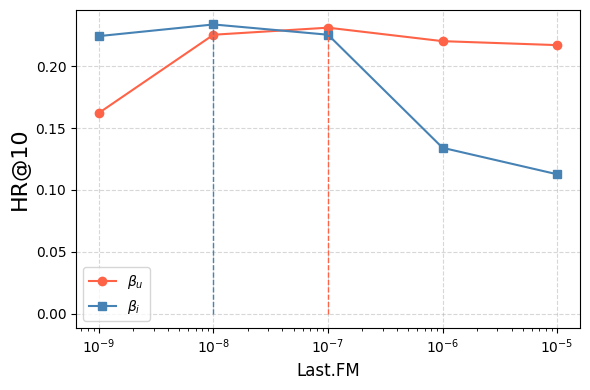

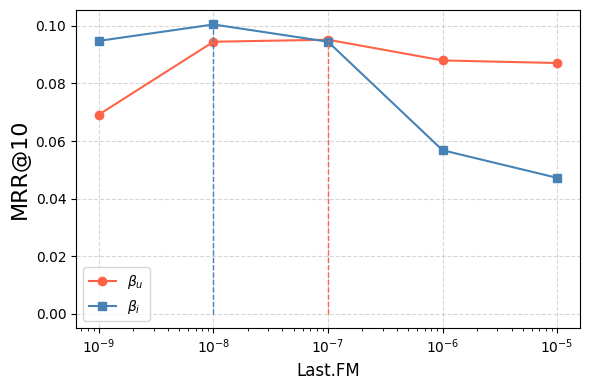

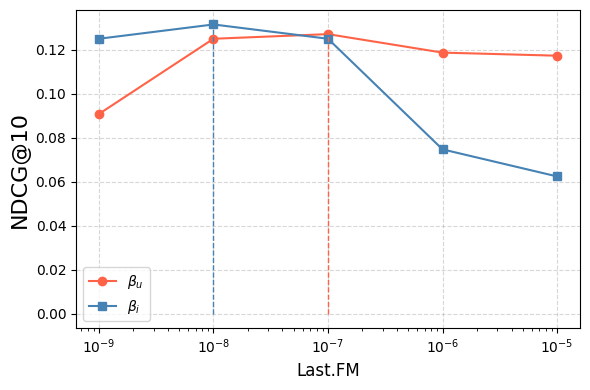

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1e-9, 1e-8, 1e-7, 1e-6, 1e-5])

user = {
    "HR@10":   [0.1623, 0.2255, 0.2312, 0.2203, 0.2171],
    "MRR@10":  [0.0692, 0.0945, 0.0952, 0.0880, 0.0871],
    "NDCG@10": [0.0908, 0.1250, 0.1271, 0.1187, 0.1173],
}

item = {
    "HR@10":   [0.2244, 0.2338, 0.2255, 0.1341, 0.1127],
    "MRR@10":  [0.0948, 0.1005, 0.0945, 0.0568, 0.0472],
    "NDCG@10": [0.1250, 0.1315, 0.1250, 0.0747, 0.0624],
}

metrics = ["HR@10", "MRR@10", "NDCG@10"]

for metric in metrics:
    plt.figure(figsize=(6, 4))

    # curves
    plt.plot(x, user[metric], marker='o', linestyle='-', label=r'$\beta_u$', color='tomato')
    plt.plot(x, item[metric], marker='s', linestyle='-', label=r'$\beta_i$', color='steelblue')

    plt.xscale('log')
    plt.xlabel("Last.FM", fontsize=12)
    plt.ylabel(metric, fontsize=16)

    # best points
    best_u_idx = np.argmax(user[metric])
    best_i_idx = np.argmax(item[metric])

    # vertical dashed lines: from 0 to best value (not crossing the point)
    plt.vlines(
        x[best_u_idx],
        ymin=0,
        ymax=user[metric][best_u_idx],
        linestyles='--',
        linewidth=1,
        colors='tomato'
    )
    plt.vlines(
        x[best_i_idx],
        ymin=0,
        ymax=item[metric][best_i_idx],
        linestyles='--',
        linewidth=1,
        colors='steelblue'
    )

    plt.grid(True, which="major", linestyle='--', alpha=0.5)

    # fixed legend position: lower left
    plt.legend(loc='lower left')

    plt.tight_layout()



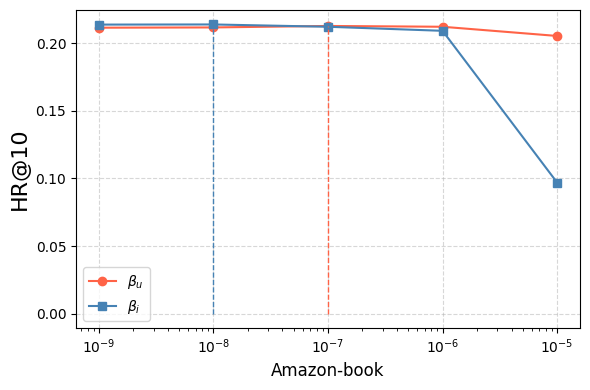

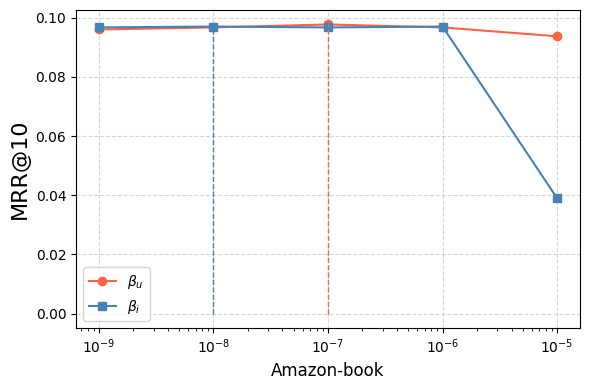

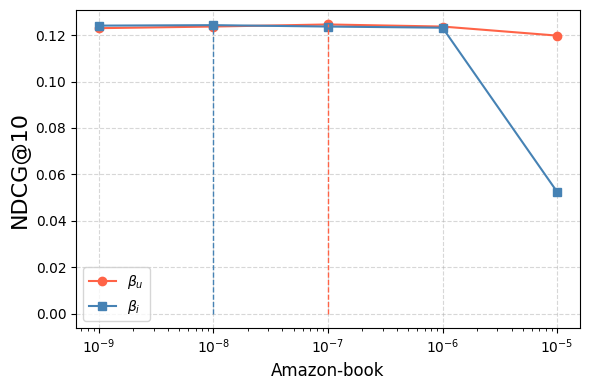

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1e-9, 1e-8, 1e-7, 1e-6, 1e-5])

# ===== 使用你最新给出的数据 =====
user = {
    "HR@10":   [0.2115, 0.2117, 0.2128, 0.2122, 0.2054],
    "MRR@10":  [0.0960, 0.0967, 0.0977, 0.0967, 0.0937],
    "NDCG@10": [0.1230, 0.1237, 0.1246, 0.1237, 0.1198],
}

item = {
    "HR@10":   [0.2138, 0.2139, 0.2122, 0.2092, 0.0970],
    "MRR@10":  [0.0967, 0.0970, 0.0967, 0.0970, 0.0390],
    "NDCG@10": [0.1241, 0.1243, 0.1237, 0.1232, 0.0525],
}

metrics = ["HR@10", "MRR@10", "NDCG@10"]

for metric in metrics:
    plt.figure(figsize=(6, 4))

    # curves
    plt.plot(x, user[metric], marker='o', linestyle='-', label=r'$\beta_u$', color='tomato')
    plt.plot(x, item[metric], marker='s', linestyle='-', label=r'$\beta_i$', color='steelblue')

    plt.xscale('log')
    plt.xlabel("Amazon-book", fontsize=12)
    plt.ylabel(metric, fontsize=16)

    # best indices
    best_u_idx = np.argmax(user[metric])
    best_i_idx = np.argmax(item[metric])

    # vertical dashed lines (from 0 to best point)
    plt.vlines(
        x[best_u_idx],
        ymin=0,
        ymax=user[metric][best_u_idx],
        linestyles='--',
        linewidth=1,
        colors='tomato'
    )
    plt.vlines(
        x[best_i_idx],
        ymin=0,
        ymax=item[metric][best_i_idx],
        linestyles='--',
        linewidth=1,
        colors='steelblue'
    )

    plt.grid(True, which="major", linestyle='--', alpha=0.5)
    plt.legend(loc='lower left')

    plt.tight_layout()


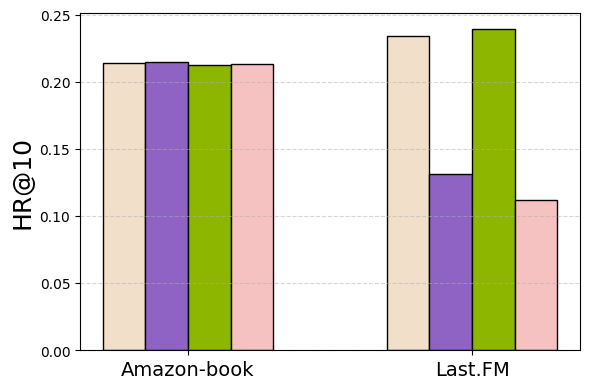

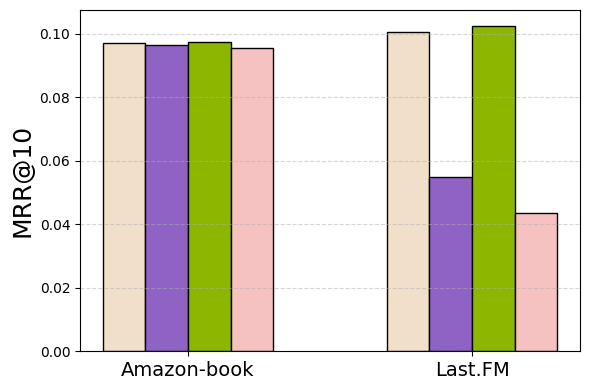

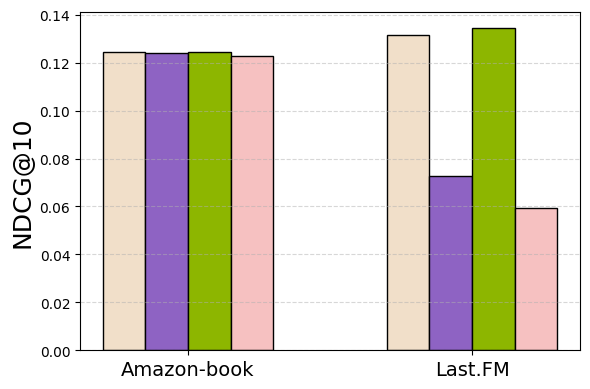

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# 数据集与结果
# =============================
datasets = ["Amazon-book", "Last.FM"]

results = {
    "Amazon-book": {
        "w":       {"HR@10": 0.2139, "MRR@10": 0.0970, "NDCG@10": 0.1243},
        "w/o_u":   {"HR@10": 0.2146, "MRR@10": 0.0964, "NDCG@10": 0.1240},
        "w/o_i":   {"HR@10": 0.2128, "MRR@10": 0.0974, "NDCG@10": 0.1244},
        "w/o_ui":  {"HR@10": 0.2132, "MRR@10": 0.0954, "NDCG@10": 0.1229},
    },
    "Last.FM": {
        "w":       {"HR@10": 0.2338, "MRR@10": 0.1005, "NDCG@10": 0.1315},
        "w/o_u":   {"HR@10": 0.1310, "MRR@10": 0.0549, "NDCG@10": 0.0726},
        "w/o_i":   {"HR@10": 0.2396, "MRR@10": 0.1023, "NDCG@10": 0.1345},
        "w/o_ui":  {"HR@10": 0.1117, "MRR@10": 0.0436, "NDCG@10": 0.0595},
    }
}

methods = ["w", "w/o_u", "w/o_i", "w/o_ui"]
colors = ["#9bbbf2", "#5186f0", "#406abd", "#485570"]
# colors = ["#f1dfc9", "#8e63c3", "#8db600", "#f6c1c1"]

metrics = ["HR@10", "MRR@10", "NDCG@10"]

# =============================
# 作图
# =============================
x = np.arange(len(datasets))
width = 0.15

for metric in metrics:
    plt.figure(figsize=(6, 4))

    for i, method in enumerate(methods):
        values = [results[d][method][metric] for d in datasets]
        plt.bar(
            x + (i - 1.5) * width,
            values,
            width=width,
            label=method.replace("_", " "),
            color=colors[i],
            edgecolor="black"
        )

    plt.xticks(x, datasets, fontsize=14)
    plt.ylabel(metric, fontsize=18)

    plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
